# Movie_DataQuest - Search For The Best Single Factor

In [1]:
# Dependencies
import pandas as pd
import requests
import json
from pprint import pprint
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy.stats import f_oneway
import random
import numpy as np
from config import api_key_txt
#from config import tmdb_api_key

# Project description and outline:

Description: How do various movie characteristics affect movie success?

Definition of Success:  Total U.S. Box Office Receipts

Characteristics Considered: 
  - Genre
  - Run time
  - Budget
  - Critical reviews
  - User reviews
  - Awards / nominations
  - MPAA Rating

Hypothesis: 1) Movie box office receipts are influenced by the above characteristics.  2) The closer box office receipts correlate with the various movie characteristics, the stronger the influence of the given characteristic on movie success.
Which of these characteristics have the closest correlation with box office success?



### Steve's Code Goes Here

### Introduction to IMDb Database Preperation   
Movie Data Sets Utilized:  Internet Movie Database (IMDb) & Online Media Database (OMDb).

The IMDb contains a greater range of quantified movie characteristics than does the OMDb.  For 
this reason the IMDb was used to provide the bulk of our testing criteria.  In order to limit 
the scope of the data we pulled only information regarding movies that were feature-length, 
non-"adult", and were released between 2000 and 2019.


In [2]:
### INITIAL DATA SET ###

# Our first data set is a CSV of film data derived from the data available at https://www.imdb.com/interfaces/. 
# It contains feature-length films released between 2000 and 2019.

# Importing this CSV as a dataframe

imdb_csv = "Resources/trimmed_IMDB_data.csv"
imdb_df = pd.read_csv(imdb_csv, encoding="UTF-8")

imdb_df

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres
0,tt0011216,Spanish Fiesta,La fête espagnole,2019,67,Drama
1,tt0016906,Frivolinas,Frivolinas,2014,80,"Comedy,Musical"
2,tt0018295,El puño de hierro,El puño de hierro,2004,40,"Action,Drama"
3,tt0035423,Kate & Leopold,Kate & Leopold,2001,118,"Comedy,Fantasy,Romance"
4,tt0036177,Muhomatsu no issho,Muhomatsu no issho,2008,100,"Action,Adventure"
...,...,...,...,...,...,...
180341,tt9916186,Illenau - die Geschichte einer ehemaligen Heil...,Illenau - die Geschichte einer ehemaligen Heil...,2017,84,Documentary
180342,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123,Drama
180343,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,57,Documentary
180344,tt9916680,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,2007,100,Documentary


In [3]:
### REFINING DATA SET ###

# Our IMDB data contains hundreds of thousands of movies, many of which had no theatrical release.
# We will combine this data with data constructed from https://movielens.org/, which focuses on released films.

# Importing movielens CSV as a dataframe

movielens_csv = "Resources/movielens_links.csv"
movielens_df =  pd.read_csv(movielens_csv, encoding="UTF-8")

movielens_df

,movieId,imdbId,tmdbId,imdbTTID
0,88674,8,105158.0,tt0000008
1,140539,3,88013.0,tt0000003
2,172063,1,16612.0,tt0000001
3,180695,7,159895.0,tt0000007
4,98981,12,160.0,tt0000012
...,...,...,...,...
62418,209051,11108064,642749.0,tt11108064
62419,209085,10768348,631420.0,tt10768348
62420,209133,10192640,519334.0,tt10192640
62421,209145,10199670,595924.0,tt10199670


In [4]:
# Combining the dataframes to find films that are in both

# Renaming themovielens_df "imdbTTID" column to match our imdb_df

movielens_df = movielens_df.rename(columns={"imdbTTID": "tconst"})

# Merging dataframes

big_df = imdb_df.merge(movielens_df, how="inner")

big_df


,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,movieId,imdbId,tmdbId
0,tt0035423,Kate & Leopold,Kate & Leopold,2001,118,"Comedy,Fantasy,Romance",4992,35423,11232.0
1,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122,Drama,159163,69049,299782.0
2,tt0110476,Master i Margarita,Master i Margarita,2006,125,"Drama,Fantasy",167420,110476,63163.0
3,tt0113026,The Fantasticks,The Fantasticks,2000,86,"Musical,Romance",4193,113026,62127.0
4,tt0114722,3 noches,3 noches,2001,105,"Crime,Thriller",185453,114722,276251.0
...,...,...,...,...,...,...,...,...,...
27873,tt9866700,Paranormal Investigation,Paranormal Investigation,2018,92,"Horror,Thriller",200550,9866700,585997.0
27874,tt9872556,Ordinary Happiness,Momenti di trascurabile felicità,2019,93,"Comedy,Fantasy",200102,9872556,583029.0
27875,tt9876160,Convoy 48,Koridor bessmertiya,2019,140,"Drama,War",203980,9876160,575333.0
27876,tt9900060,Lupin the Third: Fujiko Mine's Lie,Lupin the IIIrd: Mine Fujiko no Uso,2019,58,"Adventure,Animation,Crime",205539,9900060,587870.0


In [ ]:
### GETTING ADDITIONAL DATA FROM TMDB ###

# Selecting a sample of films for the TMDB API call

# Assigning random number
for index, row in big_df.iterrows():
    random.seed(index)
    big_df.loc[index, "randomNumber"] = random.random()

In [ ]:
# Sorting by random number to randomize
big_df = big_df.sort_values("randomNumber")

# Trimming to 5,000 entries

smaller_df = pd.DataFrame(big_df[:5000])

smaller_df

In [ ]:
# Pulling additional data via a TMDB API call

# Setting base URL
url = "https://api.themoviedb.org/3/movie/"

# Looping through dataframe
for index, row in smaller_df.iterrows():
    movie_id = row["tmdbId"]
    
    full_url = url + str(movie_id) + "?api_key=" + tmdb_api_key
    movie_data = requests.get(full_url).json()

#Setting up error handling and adding data to dataframe

    try:
        smaller_df.loc[index, "Budget"] = movie_data["budget"]
    except:
        smaller_df.loc[index, "Budget"] = "N/A"
        
    try:
        smaller_df.loc[index, "Box Office"] = movie_data["revenue"]
    except:
        smaller_df.loc[index, "Box Office"] = "N/A"
    
smaller_df

In [ ]:
### TRIMMING DATA FOR OMDB API CALLS ###

# Trimming dataframe to only items with Box Office data

boxoffice_df = smaller_df[smaller_df["Box Office"] != "N/A"]
boxoffice_df = boxoffice_df[boxoffice_df["Box Office"] != 0.0]

# Recasting Budget and Box Office as integers

boxoffice_df[['Budget', 'Box Office']] = boxoffice_df[['Budget', 'Box Office']].astype(int)

# Replacing missing values with Nan

boxoffice_df.replace(0, np.nan, inplace=True)

boxoffice_df

In [ ]:
# Reducing to 900 items

sample_df = pd.DataFrame(boxoffice_df[:900])

# Exporting as CSV to preserve data between uses

sample_df.to_csv("Resources/sample.csv",index=False)

In [5]:
# Importing new dataframe from CSV to preserve data between uses

omdb_csv = "Resources/sample.csv"
omdb_api_df = pd.read_csv(omdb_csv, encoding="UTF-8")

omdb_api_df

,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,movieId,imdbId,tmdbId,randomNumber,Budget,Box Office
0,tt6768578,Dogman,Dogman,2018,103,"Crime,Drama,Thriller",188675,6768578,483184.0,0.000094,NaN,5080147
1,tt1637706,Our Idiot Brother,Our Idiot Brother,2011,90,"Comedy,Drama",88672,1637706,59968.0,0.000106,5000000.0,24816118
2,tt1486185,Red Riding Hood,Red Riding Hood,2011,100,"Fantasy,Horror,Mystery",85397,1486185,49730.0,0.000177,42000000.0,89162162
3,tt1373243,Tarif Novogodniy,Tarif Novogodniy,2008,83,"Comedy,Fantasy,Romance",171549,1373243,50530.0,0.000196,3200000.0,3877492
4,tt0337879,Blackball,Blackball,2003,96,"Comedy,Drama,Sport",32128,337879,15443.0,0.000279,NaN,48000
...,...,...,...,...,...,...,...,...,...,...,...,...
895,tt1347007,Hidden,Skjult,2009,95,"Horror,Thriller",144412,1347007,24821.0,0.133336,2215773.0,1489526
896,tt0195714,Final Destination,Final Destination,2000,98,"Horror,Thriller",3409,195714,9532.0,0.133878,23000000.0,112880294
897,tt1457767,The Conjuring,The Conjuring,2013,112,"Horror,Mystery,Thriller",103688,1457767,138843.0,0.133941,13000000.0,319494638
898,tt0280486,Bad Company,Bad Company,2002,116,"Action,Comedy,Thriller",5414,280486,3132.0,0.134483,70000000.0,65977295


#### Conclusion/Segway
The size of the IMDb data set was....   And contained Genre, Run time, Budget, Critical Reviews, User Review, Awards/Nominations and MPAA Ratings.

After the database was acquired and cleaned it was merged with a sample of movies from the OM

### Jim's Code Goes Here

## OMDB Preparation:
    
While the Open Movie Database site does not contain the extent of the data provided by the IMDB and MovieLens it does contain the movie review data we are interested in analyzing.  

Objective:  Add review information to the filtered IMDB/MovieLens data by merging using the imdb movie id (tconst).

In [6]:
# # Get a list of IMDB ids 
movie_ids = omdb_api_df['tconst'].tolist()
movie_ids

['tt6768578',
 'tt1637706',
 'tt1486185',
 'tt1373243',
 'tt0337879',
 'tt1375666',
 'tt9795368',
 'tt1446714',
 'tt2345759',
 'tt0324127',
 'tt0247638',
 'tt4044364',
 'tt4291600',
 'tt0342258',
 'tt0165982',
 'tt2948356',
 'tt4537362',
 'tt2194499',
 'tt2121382',
 'tt0381270',
 'tt0880578',
 'tt0238948',
 'tt1999987',
 'tt4129428',
 'tt1377278',
 'tt1926313',
 'tt1410063',
 'tt1410051',
 'tt0419749',
 'tt3508112',
 'tt7818580',
 'tt1270835',
 'tt0381681',
 'tt5938084',
 'tt0486655',
 'tt0266391',
 'tt1841642',
 'tt1179069',
 'tt0200550',
 'tt8359816',
 'tt5838806',
 'tt1216491',
 'tt0279112',
 'tt3569356',
 'tt2671706',
 'tt5221894',
 'tt1656186',
 'tt7016254',
 'tt1151309',
 'tt3064298',
 'tt1034415',
 'tt1313104',
 'tt0180093',
 'tt3179568',
 'tt2372678',
 'tt0492466',
 'tt7158430',
 'tt2823054',
 'tt1592525',
 'tt0449086',
 'tt4466894',
 'tt4520364',
 'tt0467197',
 'tt1235189',
 'tt6556670',
 'tt7967412',
 'tt0430912',
 'tt0390109',
 'tt0859635',
 'tt1423995',
 'tt2926810',
 'tt31

In [ ]:
# Establish empty lists to hold review information
tconst = []
rated = []
metascore =[]
imdb_rating = []
imdb_votes = []
rotten_tomatoes = []


In [ ]:
# movie we want to search for based on the movie id.
url = "http://www.omdbapi.com/?i="
api_key_tx = "&apikey=" + api_key_txt


In [ ]:
# Performing a GET request

for id in movie_ids:
    
    response = requests.get(url + id +  api_key_tx)
    data = response.json()
    tconst.append(id)
        
    # Test to make sure data is appended successfully
    try:
        rated.append(data['Rated'])
    except:
        rated.append('N/A')

    try:
        metascore.append(data['Metascore'])
    except:
        metascore.append('N/A')

    try:
        imdb_rating.append(data['imdbRating'])
    except:
        imdb_rating.append('N/A')

    try:
        imdb_votes.append(data['imdbVotes'])
    except:
        imdb_votes.append('N/A')
    
    # Look for "Rotten Tomatoes" reviews and append if present  
    rIndex = 0
    rDone = 0
    rtScore = ""
    try:
        for x in data['Ratings']:
            if data["Ratings"][rIndex]["Source"] == "Rotten Tomatoes":
                rtScore = data['Ratings'][rIndex]["Value"]
                rIndex += 1
                rDone = 1
            else:
                if rDone == 0:
                    rIndex += 1
                    rtScore = 'N/A'
                else:
                    pass
        rotten_tomatoes.append(rtScore)
        
    except:
        rotten_tomatoes.append('N/A')
        


In [ ]:
# Create new DataFrame
# Assure resulting data works with analysis by creating float outputs 

movie_df = pd.DataFrame({'tconst' : tconst, 'Rated' : rated, 'Metascore' :  metascore,  'IMDB Rating' : imdb_rating, 
                         'IMDB Votes' : imdb_votes, "Rotten Tomatoes" : rotten_tomatoes })
                         
movie_df["Metascore"] = movie_df["Metascore"].replace('N/A',np.nan)
movie_df["Metascore"] = movie_df["Metascore"].astype(float)

movie_df["IMDB Rating"] = movie_df["IMDB Rating"].replace('N/A',np.nan)
movie_df["IMDB Rating"] = movie_df["IMDB Rating"].astype(float)

movie_df["IMDB Votes"] = movie_df["IMDB Votes"].replace(',',"", regex=True).replace('N/A',np.nan)
movie_df["IMDB Votes"] = movie_df["IMDB Votes"].astype(float)

movie_df["Rotten Tomatoes"] = movie_df["Rotten Tomatoes"].replace('%',"", regex=True).replace('N/A',np.nan)
movie_df["Rotten Tomatoes"] = movie_df["Rotten Tomatoes"].astype(float)
    
# movie_df.dtypes


In [ ]:
# Merge movie_df with omdb_api_df to get 900 movies by IMDB ID
movie_sample = pd.merge(omdb_api_df, movie_df, on = "tconst")

movie_sample

In [ ]:
# # Exporting as CSV to preserve data between uses
movie_sample.to_csv("Resources/movie_sample.csv",index=False)

In [7]:
# Use csv for analysis
movie_sample_csv = "Resources/movie_sample.csv"
movie_sample = pd.read_csv(movie_sample_csv, encoding="UTF-8")

movie_sample

,Unnamed: 0,Unnamed: 0.1,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,movieId,imdbId,tmdbId,randomNumber,Budget,Box Office,Rated,Metascore,IMDB Rating,IMDB Votes,Rotten Tomatoes
0,0,0,tt6768578,Dogman,Dogman,2018,103,"Crime,Drama,Thriller",188675,6768578,483184.0,0.000094,NaN,5080147,Not Rated,71.0,7.2,24554.0,84.0
1,1,1,tt1637706,Our Idiot Brother,Our Idiot Brother,2011,90,"Comedy,Drama",88672,1637706,59968.0,0.000106,5000000.0,24816118,R,60.0,6.4,86111.0,70.0
2,2,2,tt1486185,Red Riding Hood,Red Riding Hood,2011,100,"Fantasy,Horror,Mystery",85397,1486185,49730.0,0.000177,42000000.0,89162162,PG-13,29.0,5.5,110023.0,10.0
3,3,3,tt1373243,Tarif Novogodniy,Tarif Novogodniy,2008,83,"Comedy,Fantasy,Romance",171549,1373243,50530.0,0.000196,3200000.0,3877492,NaN,NaN,6.3,662.0,NaN
4,4,4,tt0337879,Blackball,Blackball,2003,96,"Comedy,Drama,Sport",32128,337879,15443.0,0.000279,NaN,48000,R,NaN,5.6,4113.0,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,895,895,tt1347007,Hidden,Skjult,2009,95,"Horror,Thriller",144412,1347007,24821.0,0.133336,2215773.0,1489526,R,NaN,5.7,2922.0,NaN
896,896,896,tt0195714,Final Destination,Final Destination,2000,98,"Horror,Thriller",3409,195714,9532.0,0.133878,23000000.0,112880294,R,36.0,6.7,240349.0,35.0
897,897,897,tt1457767,The Conjuring,The Conjuring,2013,112,"Horror,Mystery,Thriller",103688,1457767,138843.0,0.133941,13000000.0,319494638,R,68.0,7.5,472183.0,86.0
898,898,898,tt0280486,Bad Company,Bad Company,2002,116,"Action,Comedy,Thriller",5414,280486,3132.0,0.134483,70000000.0,65977295,PG-13,37.0,5.6,47217.0,10.0


In [ ]:
# movie_sample.to_csv("Resources/movie_sample.csv")

#### Conclusion/Segway
The size of the IMDb data set was....   And contained Genre, Run time, Budget, Critical Reviews, User Review, Awards/Nominations and MPAA Ratings.

Once our dataset was established we were ready to run our analysis.

Segway to Box Office vs. Runtime Correlations (Kelly's stuff)

### Kelly's Code Here

## Box Office vs. Runtime Correlations
In completing the box office/runtime correlation we had the following considerations....
Does the runtime of a movie affect the Box Office Sales of a movie?
The plot of the movie sample is showing that most of the movies are all around the same runtime.  Longer run times do not seem to increase box office sales nor is there a decrease and does not seem to have a direct correlation to the box office performance.  

For both the run time and budget correlations the data sample had to be reduced to take out the NaN in order to do the linear regression.


In [34]:
test_csv = ("Resources/movie_sample.csv")
movie_sample = pd.read_csv(test_csv)

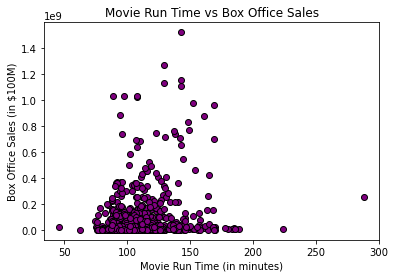

In [35]:
# Correlate Box Office v. Run time


x_values = movie_sample["runtimeMinutes"]
y_values = movie_sample["Box Office"]
plt.xlabel("Movie Run Time (in minutes)")
plt.ylabel("Box Office Sales (in $100M)")
plt.title("Movie Run Time vs Box Office Sales")
plt.scatter(x_values, y_values, marker = "o", facecolors = "purple", edgecolors="black")

plt.show()


The r-value is: 0.04518342598048904


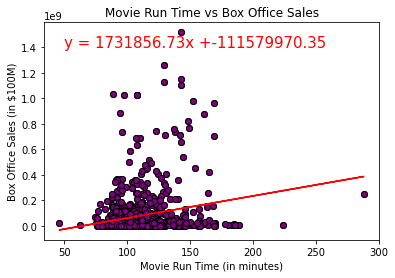

In [36]:
x_values = movie_sample["runtimeMinutes"]
y_values = movie_sample["Box Office"]
plt.xlabel("Movie Run Time (in minutes)")
plt.ylabel("Box Office Sales")
plt.title("Movie Run Time vs Box Office Sales")
plt.scatter(x_values, y_values, marker = "o", facecolors = "purple", edgecolors="black")

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_values, y_values, marker = "o", facecolors="purple", edgecolors="black")
plt.plot(x_values,regress_values,"r-")

plt.xlabel("Movie Run Time (in minutes)")
plt.ylabel("Box Office Sales (in $100M)")
plt.title("Movie Run Time vs Box Office Sales")
plt.annotate(line_eq,(50,1400000000),fontsize=15,color="red")


print(f"The r-value is: {rvalue**2}")


plt.show()

Box Office Vs Movie Budget Amount
Does the movie budget amout affect the Box office sales of a movie?
There could be a correlation based on the sample.  It does appear that the higher budgeted movies do better at the box office. Also, the movies that have around the same budget amount have similar box office sales.



In [40]:
# Correlate Box Office v. Budget

budget_sample = movie_sample[["Budget","Box Office"]].copy()

budget_sample = budget_sample.dropna()

budget_sample

,Budget,Box Office
1,5000000.0,24816118
2,42000000.0,89162162
3,3200000.0,3877492
5,160000000.0,825532764
7,130000000.0,403170142
...,...,...
895,2215773.0,1489526
896,23000000.0,112880294
897,13000000.0,319494638
898,70000000.0,65977295


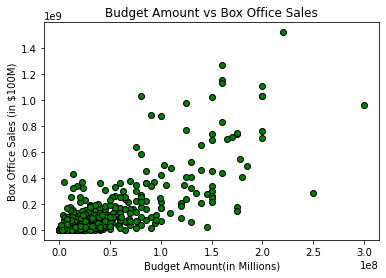

In [43]:
x_values = budget_sample["Budget"]
y_values = budget_sample["Box Office"]
plt.xlabel("Budget Amount(in Millions)")
plt.ylabel("Box Office Sales (in $100M)")
plt.title("Budget Amount vs Box Office Sales")
plt.scatter(x_values, y_values, marker = "o", facecolors = "green", edgecolors="black")

plt.show()

The r-value is: 0.6029642311689566


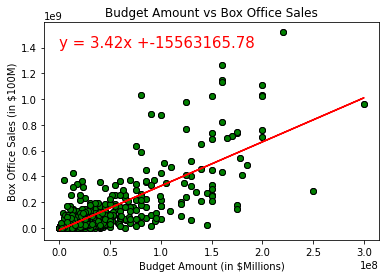

In [44]:
x_values = budget_sample["Budget"]
y_values = budget_sample["Box Office"]

plt.xlabel("Budget Amount")
plt.ylabel("Box Office Sales (in $100M)")

plt.title("Budget Amount(in $Millions) vs Box Office Sales(in $100M)")
plt.scatter(x_values, y_values, marker = "o", facecolors = "green", edgecolors="black")

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_values, y_values, marker = "o", facecolors="green", edgecolors="black")
plt.plot(x_values,regress_values,"r-")

plt.xlabel("Budget Amount (in $Millions)")
plt.ylabel("Box Office Sales (in $100M)")

plt.title("Budget Amount vs Box Office Sales")
plt.annotate(line_eq,(0.25,1400000000),fontsize=15,color="red")


print(f"The r-value is: {rvalue**2}")


plt.show()

#### Conclusion/Segway
Conclusios about MPAA Rating analysis
Box Office vs. Critical Review's (Phillips' stuff)


### Philips' Code Goes Here

## Box Office vs. Critical Reviews 
In completing the box critica reviews we had the following considerations....
and face certain issues in cleaning the data, etc. etc. ...

In [49]:
movie_sample

,Unnamed: 0,Unnamed: 0.1,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,movieId,imdbId,tmdbId,randomNumber,Budget,Box Office,Rated,Metascore,IMDB Rating,IMDB Votes,Rotten Tomatoes
0,0,0,tt6768578,Dogman,Dogman,2018,103,"Crime,Drama,Thriller",188675,6768578,483184.0,0.000094,NaN,5080147,Not Rated,71.0,7.2,24554.0,84.0
1,1,1,tt1637706,Our Idiot Brother,Our Idiot Brother,2011,90,"Comedy,Drama",88672,1637706,59968.0,0.000106,5000000.0,24816118,R,60.0,6.4,86111.0,70.0
2,2,2,tt1486185,Red Riding Hood,Red Riding Hood,2011,100,"Fantasy,Horror,Mystery",85397,1486185,49730.0,0.000177,42000000.0,89162162,PG-13,29.0,5.5,110023.0,10.0
3,3,3,tt1373243,Tarif Novogodniy,Tarif Novogodniy,2008,83,"Comedy,Fantasy,Romance",171549,1373243,50530.0,0.000196,3200000.0,3877492,NaN,NaN,6.3,662.0,NaN
4,4,4,tt0337879,Blackball,Blackball,2003,96,"Comedy,Drama,Sport",32128,337879,15443.0,0.000279,NaN,48000,R,NaN,5.6,4113.0,41.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,895,895,tt1347007,Hidden,Skjult,2009,95,"Horror,Thriller",144412,1347007,24821.0,0.133336,2215773.0,1489526,R,NaN,5.7,2922.0,NaN
896,896,896,tt0195714,Final Destination,Final Destination,2000,98,"Horror,Thriller",3409,195714,9532.0,0.133878,23000000.0,112880294,R,36.0,6.7,240349.0,35.0
897,897,897,tt1457767,The Conjuring,The Conjuring,2013,112,"Horror,Mystery,Thriller",103688,1457767,138843.0,0.133941,13000000.0,319494638,R,68.0,7.5,472183.0,86.0
898,898,898,tt0280486,Bad Company,Bad Company,2002,116,"Action,Comedy,Thriller",5414,280486,3132.0,0.134483,70000000.0,65977295,PG-13,37.0,5.6,47217.0,10.0


In [52]:
#Correlate Box Office v. Metascore

meta_sample = movie_sample[["Metascore","Box Office"]].copy()

meta_sample = meta_sample.dropna()

meta_sample

,Metascore,Box Office
0,71.0,5080147
1,60.0,24816118
2,29.0,89162162
5,74.0,825532764
7,64.0,403170142
...,...,...
894,85.0,20117339
896,36.0,112880294
897,68.0,319494638
898,37.0,65977295


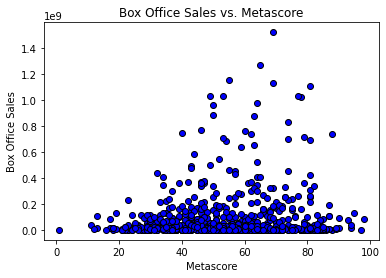

In [53]:
#Plot out Box Office versus Metascore
x_values = meta_sample["Metascore"]
y_values = meta_sample["Box Office"]

plt.scatter(x_values, y_values, marker = "o", facecolors = "blue", edgecolors="black")
plt.xlabel("Metascore")
plt.ylabel("Box Office Sales")
plt.title("Box Office Sales vs. Metascore")

plt.show()

The r-value is: 0.006781865267542999


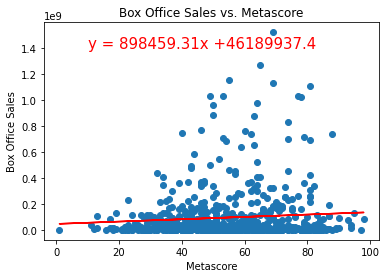

In [57]:
#Add the linear regression equation and line to plot
x_values = meta_sample["Metascore"]
y_values = meta_sample["Box Office"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_values, y_values)
plt.plot(x_values,regress_values,"r-")

plt.xlabel("Metascore")
plt.ylabel("Box Office Sales")
plt.title("Box Office Sales vs. Metascore")
plt.annotate(line_eq,(10,14e8),fontsize=15,color="red")

print(f"The r-value is: {rvalue**2}")

plt.show()


In [60]:
#Correlate Box Office v. Rotten Tomatoes Score

rt_sample = movie_sample[["Rotten Tomatoes","Box Office"]].copy()

rt_sample = rt_sample.dropna()

rt_sample

,Rotten Tomatoes,Box Office
0,84.0,5080147
1,70.0,24816118
2,10.0,89162162
4,41.0,48000
5,87.0,825532764
...,...,...
894,84.0,20117339
896,35.0,112880294
897,86.0,319494638
898,10.0,65977295


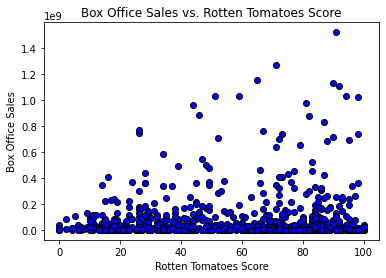

In [61]:
#Plot out box office versus user reviews
x_values = rt_sample["Rotten Tomatoes"]
y_values = rt_sample["Box Office"]

plt.scatter(x_values, y_values, marker = "o", facecolors = "blue", edgecolors="black")
plt.xlabel("Rotten Tomatoes Score")
plt.ylabel("Box Office Sales")
plt.title("Box Office Sales vs. Rotten Tomatoes Score")

plt.show()


The r-value is: 0.006976508632501131


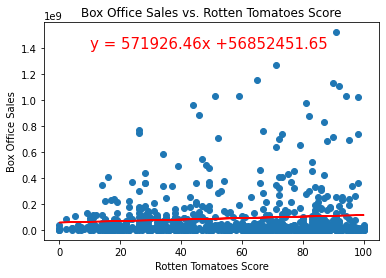

In [63]:
#Add the linear regression equation and line to plot
x_values = rt_sample["Rotten Tomatoes"]
y_values = rt_sample["Box Office"]

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_values, y_values)
plt.plot(x_values,regress_values,"r-")

plt.xlabel("Rotten Tomatoes Score")
plt.ylabel("Box Office Sales")
plt.title("Box Office Sales vs. Rotten Tomatoes Score")

plt.annotate(line_eq,(10,1400000000),fontsize=15,color="red")
print(f"The r-value is: {rvalue**2}")

plt.show()


#### Conclusion/Segway
Conclusios with  with Critical & User reviews analysis
Segway to Awards / Nominations (Jim's Stuff).




## Box Office vs IMDB Ratings & IMDB Votes
IMDB is a entertainment fan website.  Members can vote on movies and rate them if 
they include a review.  

### Observations: 
2) Based on r-values IMDB Votes (.44) have a better correlation than IMDB Ratings (.03).

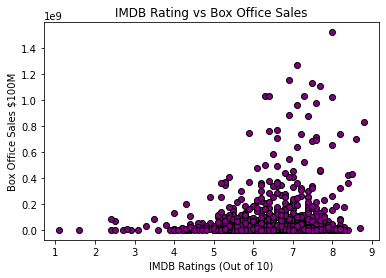

In [65]:
# Correlate Box Office v. IMDB Ratings

x_values = movie_sample["IMDB Rating"]
y_values = movie_sample["Box Office"]
plt.xlabel("IMDB Ratings (Out of 10)")
plt.ylabel("Box Office Sales $100M")
plt.title("IMDB Rating vs Box Office Sales")
plt.scatter(x_values, y_values, marker = "o", facecolors = "purple", edgecolors="black")

plt.show()


The r-value is: 0.033089183559585095


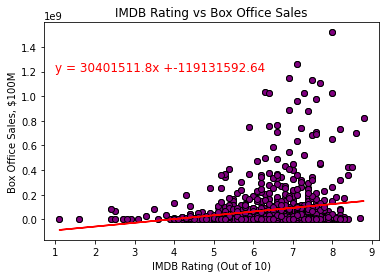

In [66]:
# Do linear Regression and plot

x_values = movie_sample["IMDB Rating"]
y_values = movie_sample["Box Office"]
plt.xlabel("IMDB Ratings")
plt.ylabel("Box Office Receipts ($)")
plt.title("IMDB Rating vs Box Office Sales")
plt.scatter(x_values, y_values, marker = "o", facecolors = "purple", edgecolors="black")

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_values, y_values, marker = "o", facecolors="purple", edgecolors="black")
plt.plot(x_values,regress_values,"r-")


plt.xlabel("IMDB Rating (Out of 10)")
plt.ylabel("Box Office Sales, $100M")
plt.title("IMDB Rating vs Box Office Sales")
plt.annotate(line_eq,(1,1200000000),fontsize=12,color="red")


print(f"The r-value is: {rvalue**2}")


plt.show()

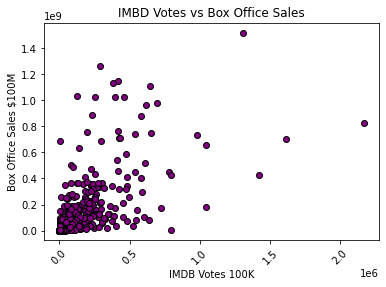

In [67]:
# Correlate Box Office v. IMDB Votes

x_values = movie_sample["IMDB Votes"]
y_values = movie_sample["Box Office"]
plt.xlabel("IMDB Votes 100K")
plt.xticks(rotation=45)
plt.ylabel("Box Office Sales $100M")
plt.title("IMBD Votes vs Box Office Sales")
plt.scatter(x_values, y_values, marker = "o", facecolors = "purple", edgecolors="black")

plt.show()



The r-value is: 0.44328562830706925


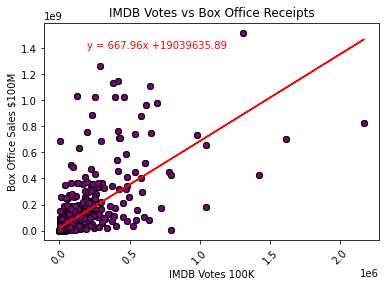

In [68]:
# Do linear Regression and plot

x_values = movie_sample["IMDB Votes"]
y_values = movie_sample["Box Office"]
plt.xlabel("IMDB Votes 100K")
plt.xticks(rotation=45)
plt.ylabel("Box Office Sales $100M")
plt.title("IMBD Votes vs Box Office Sales")
plt.scatter(x_values, y_values, marker = "o", facecolors = "purple", edgecolors="black")

(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept

line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept,2))

plt.scatter(x_values, y_values, marker = "o", facecolors="purple", edgecolors="black")
plt.plot(x_values,regress_values,"r-")


plt.xlabel("IMDB Votes 100K")
plt.ylabel("Box Office Sales $100M")
plt.title("IMDB Votes vs Box Office Receipts")
plt.annotate(line_eq,(200000,1400000000),fontsize=10,color="red")


print(f"The r-value is: {rvalue**2}")


plt.show()

#### Conclusion/Segway
The correlation plots reveal a general positive correlation but r-values indicate that neither IMDB reviews or votes correlate strongly with movie box office.

## Steve's T-test (Chi Square? ANOVA?)
I looked at movie genres & MPAA ratings.  With genres we look at 
correlations across cataegories and thus performed a different analysis
that linear regression correlations...

In [69]:
# option: Steve performs t-test across movie genre 

genreRaw = omdb_api_df["genres"].unique()
genreList = []

for x in genreRaw:
    genres = x.split(",")
    
    for y in genres:
        if not y in genreList:
            genreList.append(y)

genreList


['Crime',
 'Drama',
 'Thriller',
 'Comedy',
 'Fantasy',
 'Horror',
 'Mystery',
 'Romance',
 'Sport',
 'Action',
 'Adventure',
 'Sci-Fi',
 'History',
 'Family',
 'Biography',
 'Documentary',
 'Animation',
 'Music',
 'War',
 'Western',
 'Musical']

In [70]:
genreSeries = pd.Series(genreList)

genreDictionary = {genre: [] for genre in genreSeries}

for index, row in movie_sample.iterrows():
    for movieGenre in genreList:
        if movieGenre in row["genres"]:
            genreDictionary[movieGenre].append(row["Box Office"])
        else:
            pass

genreDictionary

{'Crime': [5080147,
  13000000,
  50871113,
  52659594,
  31600000,
  2636637,
  178471,
  5218973,
  371528,
  2106557,
  1162422,
  85416905,
  3453043,
  18850674,
  342463063,
  56681566,
  29381649,
  57777106,
  147845033,
  30718107,
  10629321,
  80000000,
  14397593,
  4900000,
  82800000,
  40400,
  5101756,
  144008,
  2000000,
  102952888,
  12000000,
  12371132,
  318155,
  23081726,
  155760117,
  9200000,
  414404,
  1404,
  4633668,
  56308881,
  214104620,
  109421911,
  130293714,
  18000000,
  12000000,
  276891,
  3736775,
  18000000,
  27975429,
  16136,
  243347,
  1102000,
  171539887,
  449681,
  41637263,
  5507396,
  3142154,
  1297401,
  2200000,
  18381890,
  95226116,
  73121,
  7766240,
  1954937,
  6732980,
  24261569,
  15478800,
  11480000,
  5169755,
  1037335,
  34266564,
  25345000,
  532269,
  36586,
  37500,
  371396,
  34533783,
  33856058,
  188441614,
  5900000,
  200242,
  59000,
  14946150,
  43880,
  310827,
  3696232,
  2500000,
  69564,
  4

In [71]:
shortGenres = {}

for key, values in genreDictionary.items():
    if len(values) > 45:
        shortGenres[key]=values

shortGenres

{'Crime': [5080147,
  13000000,
  50871113,
  52659594,
  31600000,
  2636637,
  178471,
  5218973,
  371528,
  2106557,
  1162422,
  85416905,
  3453043,
  18850674,
  342463063,
  56681566,
  29381649,
  57777106,
  147845033,
  30718107,
  10629321,
  80000000,
  14397593,
  4900000,
  82800000,
  40400,
  5101756,
  144008,
  2000000,
  102952888,
  12000000,
  12371132,
  318155,
  23081726,
  155760117,
  9200000,
  414404,
  1404,
  4633668,
  56308881,
  214104620,
  109421911,
  130293714,
  18000000,
  12000000,
  276891,
  3736775,
  18000000,
  27975429,
  16136,
  243347,
  1102000,
  171539887,
  449681,
  41637263,
  5507396,
  3142154,
  1297401,
  2200000,
  18381890,
  95226116,
  73121,
  7766240,
  1954937,
  6732980,
  24261569,
  15478800,
  11480000,
  5169755,
  1037335,
  34266564,
  25345000,
  532269,
  36586,
  37500,
  371396,
  34533783,
  33856058,
  188441614,
  5900000,
  200242,
  59000,
  14946150,
  43880,
  310827,
  3696232,
  2500000,
  69564,
  4

In [72]:
genrePairs = [   (key, value) 
            for key, values in shortGenres.items() 
            for value in values ]

genre_df = pd.DataFrame(genrePairs, columns=["Genre","Box Office"])

genre_df

,Genre,Box Office
0,Crime,5080147
1,Crime,13000000
2,Crime,50871113
3,Crime,52659594
4,Crime,31600000
...,...,...
2065,Animation,361366633
2066,Animation,473104
2067,Animation,3800000
2068,Animation,186053725


<AxesSubplot:title={'center':'Box Office'}, xlabel='Genre'>

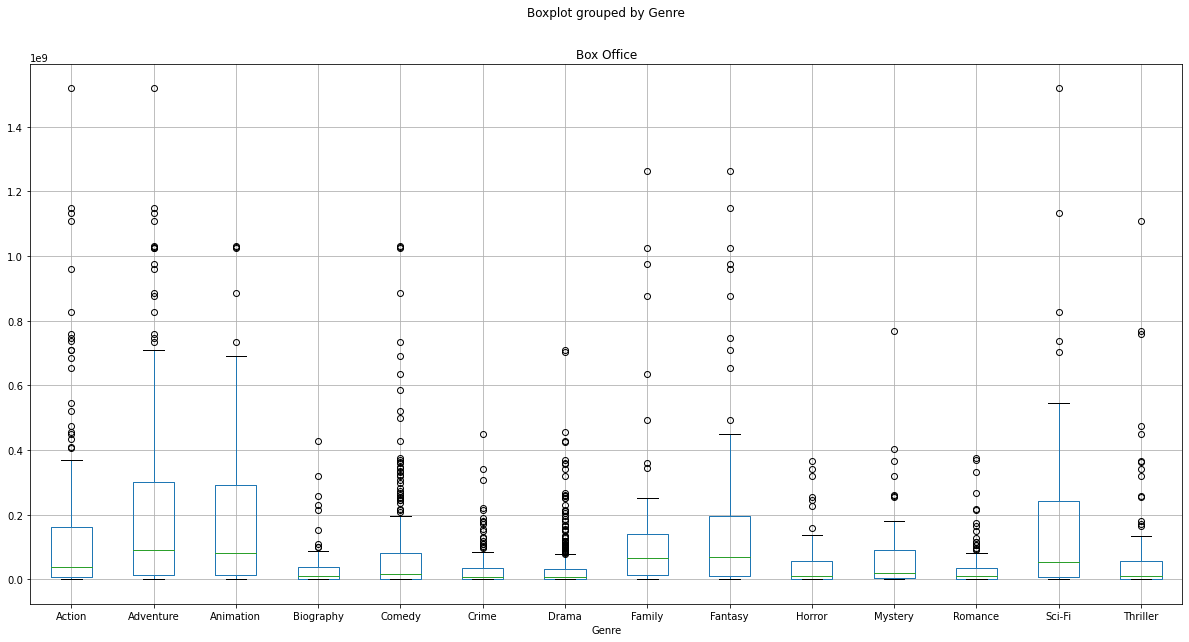

In [73]:
genre_df.boxplot("Box Office", by="Genre", figsize=(20, 10))

In [74]:
group1 = genre_df[genre_df["Genre"] == "Action"]["Box Office"]
group2 = genre_df[genre_df["Genre"] == "Adventure"]["Box Office"]
group3 = genre_df[genre_df["Genre"] == "Animation"]["Box Office"]
group4 = genre_df[genre_df["Genre"] == "Biography"]["Box Office"]
group5 = genre_df[genre_df["Genre"] == "Comedy"]["Box Office"]
group6 = genre_df[genre_df["Genre"] == "Crime"]["Box Office"]
group7 = genre_df[genre_df["Genre"] == "Drama"]["Box Office"]
group8 = genre_df[genre_df["Genre"] == "Family"]["Box Office"]
group9 = genre_df[genre_df["Genre"] == "Fantasy"]["Box Office"]
group10 = genre_df[genre_df["Genre"] == "Horror"]["Box Office"]
group11 = genre_df[genre_df["Genre"] == "Mystery"]["Box Office"]
group12 = genre_df[genre_df["Genre"] == "Romance"]["Box Office"]
group13 = genre_df[genre_df["Genre"] == "Sci-Fi"]["Box Office"]
group14 = genre_df[genre_df["Genre"] == "Thriller"]["Box Office"]

f_oneway(group1, group2, group3, group4, group5, group6, group7, group8, group9, group10, group11, group12, group13, group14)

F_onewayResult(statistic=21.969606376422718, pvalue=1.0797971720071802e-49)

In [75]:
ratings_df = pd.DataFrame(movie_sample[["Box Office", "Rated"]].copy())

ratings_df["Rated"].value_counts()

R            325
PG-13        205
Not Rated    117
PG            99
G             21
Unrated       16
TV-MA         13
TV-14          5
TV-PG          3
NC-17          3
TV-Y7          1
Name: Rated, dtype: int64

In [76]:
mpaa_df = ratings_df.loc[(ratings_df["Rated"] == "PG") | (ratings_df["Rated"] == "PG-13") | (ratings_df["Rated"] == "R")\
                         | (ratings_df["Rated"] == "Not Rated")]

mpaa_df

,Box Office,Rated
0,5080147,Not Rated
1,24816118,R
2,89162162,PG-13
4,48000,R
5,825532764,PG-13
...,...,...
895,1489526,R
896,112880294,R
897,319494638,R
898,65977295,PG-13


<AxesSubplot:title={'center':'Box Office'}, xlabel='Rated'>

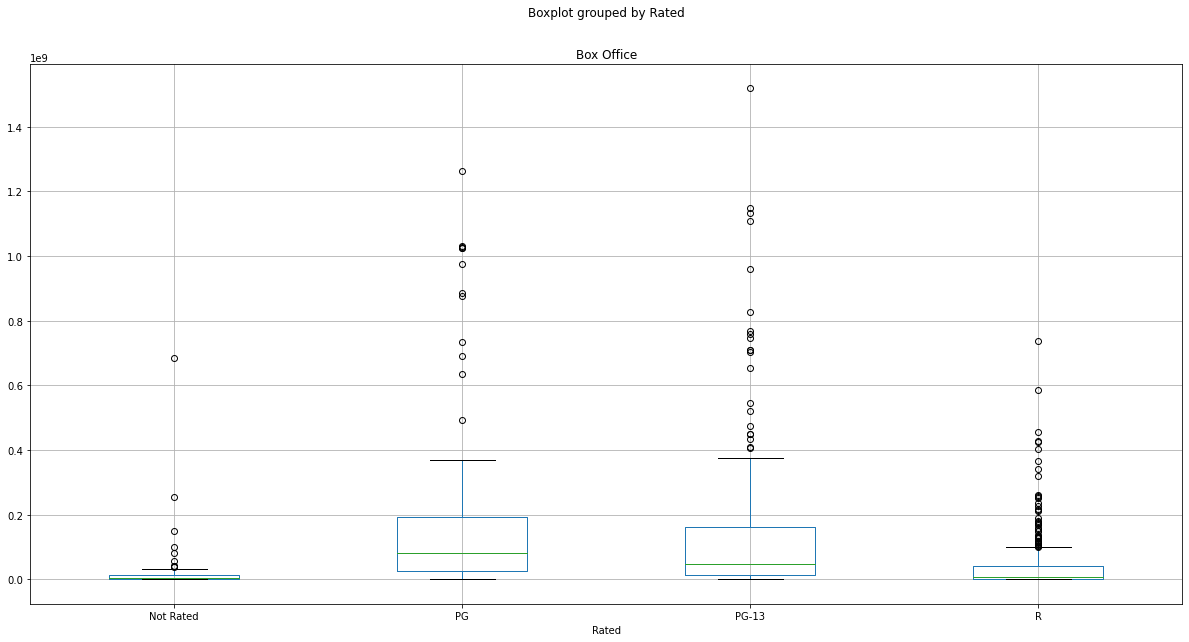

In [77]:
mpaa_df.boxplot("Box Office", by="Rated", figsize=(20, 10))

In [78]:
group1 = mpaa_df[mpaa_df["Rated"] == "Not Rated"]["Box Office"]
group2 = mpaa_df[mpaa_df["Rated"] == "PG"]["Box Office"]
group3 = mpaa_df[mpaa_df["Rated"] == "PG-13"]["Box Office"]
group4 = mpaa_df[mpaa_df["Rated"] == "R"]["Box Office"]

f_oneway(group1, group2, group3, group4)

F_onewayResult(statistic=31.515625243964518, pvalue=3.5044854695942106e-19)

#### Conclusion/Segway
Conclusions of genre and MPAA analysis
Segway to project conclusion

## Project Conclusion
In completing the box office vs. awards / nominations we had the following considerations....
and face certain issues in cleaning the data, etc. etc. ...